In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import bicgstab
import Reader as rd
from glob import glob
import matplotlib.patches as patches
import pandas as pd
import math
from scipy.misc import imread


import os

#### Methods

In [2]:
def e_neighbour_graph(img, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            result[row * colN + col][(row + rowDiff) * colN + (col + colDiff)] = 1
    return result


def fully_connected_graph(img, sigma):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for row2 in range(rowN):
                for col2 in range(colN):
                    weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                    result[row * colN + col][row2 * colN + col2] = weight
    return result


def fully_connected_e_neighbour_graph(img, sigma, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            row2 = row + rowDiff
                            col2 = col + colDiff
                            weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                            result[row * colN + col][row2 * colN + col2] = weight
    return result
'''
# Check for graph implementations
ANGLE = 0 # 0-15, 0 is front, 8 is back
path_list = glob("./stage1_aps/*.aps")
path = path_list[0]
data = rd.read_data(path_list[0])
# we only get images from one certain angle
# img = np.rot90(data[:,:, ANGLE])
# imgplt = plt.imshow(img)
plt.show()


img2 = imread("./sample.jpg")
img2 = np.asarray(img2,np.dtype(np.int32))
# plt.imshow(img2)
# plt.show()
A = np.array([[1,2,3], [0,5,6]])
# A = img2
print("Image")
print(np.shape(A))
print(A)
print("e neighbour graph")
print(e_neighbour_graph(A, 1))
print("Fully connected & e neighbour graph")
print(np.round(fully_connected_e_neighbour_graph(A, 1, 1), decimals=2))
print("Fully connected graph")
print(np.round(fully_connected_graph(A, 1), decimals=2))
'''


def laplacian(graph):
    diag = np.diag(sum(graph))
    lap = diag - graph
    return [lap, diag]


def orthogonalize(diag, s):
    nodeNum = len(diag)
    p = np.ones((nodeNum, 1)) / pow(sum(np.diag(np.diag(sum(diag)))), .5)
    projection = np.dot(np.transpose(s), np.dot(diag, p))
    v = s - projection[0][0] * p
    # return [v, projection]
    return v


def PRwalk(graph, alpha, s):
    if alpha < 0:
        print('Error: alpha must be positive!')
        return -1
    nodeNum = len(graph)
    [L, D] = laplacian(graph)
    s = orthogonalize(D, s)
    v, flag = bicgstab((L + alpha * D), np.dot(D, s),tol=1e-3, maxiter=nodeNum)

    v = np.reshape(v, (len(v), 1))

    v = orthogonalize(D, v)
    return v

# Check for method implementations
# A = np.array([[1, 2, 3], [1, 5, 6]])
# G = np.round(fully_connected_e_neighbour_graph(A, 10, 1), decimals=1)
# print("Laplacian Check")
# [L, D] = laplacian(G)
# print(L)
# print(D)
# print("Orthogonalize check")
# A = np.array([2,3,3])
# D = np.diag(A)
# s = np.array([[1], [2], [3]])
# t = orthogonalize(D, s)
# print(t)
# print("PRwalk check")
# G = np.array([[0, 1], [1, 0]])
# s = np.array([[1], [2]])
# print(PRwalk(G, 1, s)) # output should be [[-0.167], [ 0.167]]

def normalize(D, s):
    norm = np.dot(np.dot(np.transpose(s), D), s)
    v = s/math.sqrt(norm)
    return v


#### Image

In [3]:
# 0cc6fc725d4b8818415ddc06823fce98
IMAGE = "0cc6fc725d4b8818415ddc06823fce98"
myImg = np.asarray(imread(IMAGE + "/" + IMAGE + ".aps.jpg"), dtype=np.int)
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
# seed[70 * myImg.shape[1] + 78][0] = 1 # Example seed
# seed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed
seedList = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1']
for i in range(30, 111, 32):
    for j in range(50, 111, 30):
        seedList.append([i,j])
alphaListList = []
correlationListList = []
scoreListList = []
valueListList = []

#### Trying seed as normalised full image

$seed[i] = \frac{intensity[i]}{\sqrt{\sum intensity^2}}$

In [4]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed / math.sqrt(sum(sum(seed * seed)))

[L, D] = laplacian(graph)
s = orthogonalize(D, seed)
s = normalize(D, s)
exponential = 0
alpha = 2 ** exponential
v = PRwalk(graph, alpha, s)
normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
# print(normalization)
correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]

print('Threshold: ' + str(1 / len(graph)))
alphaList = []
alphaList.append(alpha)

correlationList = []
correlationList.append(correlation)
      
scoreList = []
scoreList.append(score)

valueList = []
valueList.append(v)
print('')
print('alpha: 2^' + str(exponential))
print('Correlation: ' + str(correlation))
print('Score: ' + str(score))

maxIterations = 29
minIterations = 3
for i in range(maxIterations):
    if correlation > 1 / len(graph):
        oldCorrelation = correlation
        exponential -= 1
        alpha = 2 ** exponential
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
        alphaList.append(alpha)
        correlationList.append(correlation)
        scoreList.append(score)
        valueList.append(v)
        print('')
        print('alpha: 2^' + str(exponential))
        print('Correlation: ' + str(correlation))
        print('Score: ' + str(score))
    if i == minIterations:
        print('')
        print('Starting correlation decrease check!')
    if i >= minIterations and oldCorrelation * .99 < correlation:
        break

alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.999869561584
Score: 0.0013423222989

alpha: 2^-1
Correlation: 0.999692339887
Score: 0.00122141707317

alpha: 2^-2
Correlation: 0.999339919624
Score: 0.00109906642623

alpha: 2^-3
Correlation: 0.998666345269
Score: 0.000980892779547

alpha: 2^-4
Correlation: 0.997412253385
Score: 0.000870284559473

Starting correlation decrease check!


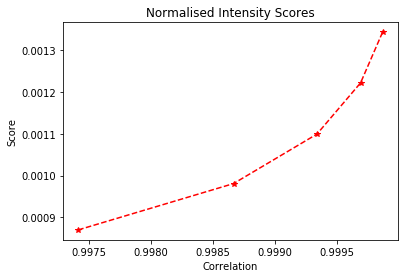

In [5]:
plt.plot(correlationList, scoreList, 'r*--')
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

Plotting each heat map
Score: 0.0013423222989
Heatmap:



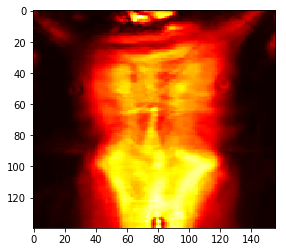

Score: 0.00122141707317
Heatmap:



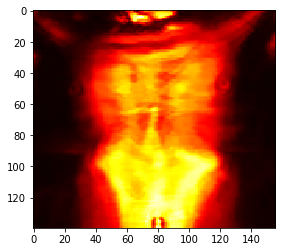

Score: 0.00109906642623
Heatmap:



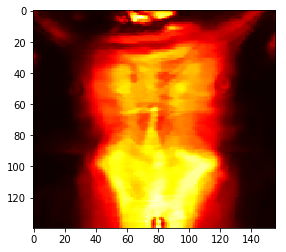

Score: 0.000980892779547
Heatmap:



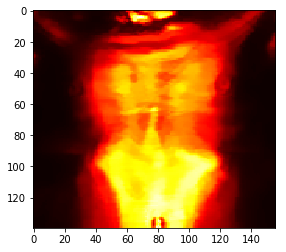

Score: 0.000870284559473
Heatmap:



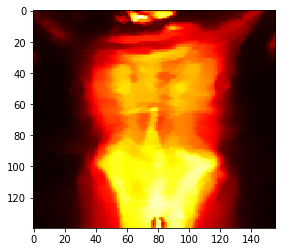

In [6]:
print('Plotting each heat map')
for item in range(len(valueList)):
    heat = np.zeros(myImg.shape)
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            heat[i][j] = valueList[item][i * myImg.shape[1] + j]
    print('Score: ' + str(scoreList[item]))
    print('Heatmap:\n')
    plt.imshow(heat, cmap='hot', interpolation='nearest')
    # plt.imshow(heat, cmap='hot', interpolation='nearest',alpha = .6)
    plt.show()

#### Trying seed as normalised Intensity Square to between 0 and 1

$seed[i] = \frac{intensity[i]^2 - min(intensity^2)}{max(intensity^2) - min(intensity^2)}$

In [7]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed * seed
seed = (seed - min(seed)) / (max(seed) - min(seed))

[L, D] = laplacian(graph)
s = orthogonalize(D, seed)
s = normalize(D, s)
exponential = 0
alpha = 2 ** exponential
v = PRwalk(graph, alpha, s)
normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
# print(normalization)
correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]

print('Threshold: ' + str(1 / len(graph)))
alphaList = []
alphaList.append(alpha)

correlationList = []
correlationList.append(correlation)
      
scoreList = []
scoreList.append(score)

valueList = []
valueList.append(v)
print('')
print('alpha: 2^' + str(exponential))
print('Correlation: ' + str(correlation))
print('Score: ' + str(score))

maxIterations = 29
minIterations = 3
for i in range(maxIterations):
    if correlation > 1 / len(graph):
        oldCorrelation = correlation
        exponential -= 1
        alpha = 2 ** exponential
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
        alphaList.append(alpha)
        correlationList.append(correlation)
        scoreList.append(score)
        valueList.append(v)
        print('')
        print('alpha: 2^' + str(exponential))
        print('Correlation: ' + str(correlation))
        print('Score: ' + str(score))
    if i == minIterations:
        print('')
        print('Starting correlation decrease check!')
    if i >= minIterations and oldCorrelation * .99 < correlation:
        break

alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.999782247764
Score: 0.00196792088806

alpha: 2^-1
Correlation: 0.999468561582
Score: 0.00175290546134

alpha: 2^-2
Correlation: 0.998814887826
Score: 0.00152515418827

alpha: 2^-3
Correlation: 0.99750932064
Score: 0.00129618193164

alpha: 2^-4
Correlation: 0.995039670258
Score: 0.00107728114754

Starting correlation decrease check!


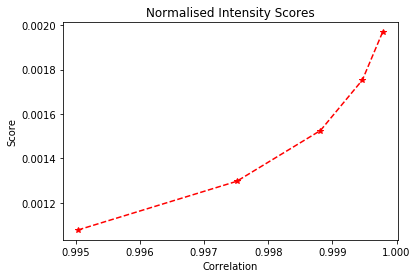

In [8]:
plt.plot(correlationList, scoreList, 'r*--')
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

Plotting each heat map
Score: 0.00196792088806
Heatmap:



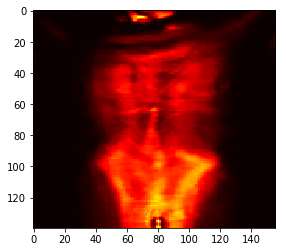

Score: 0.00175290546134
Heatmap:



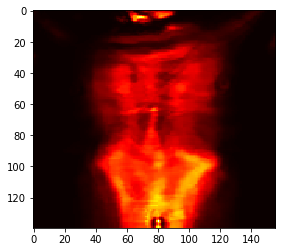

Score: 0.00152515418827
Heatmap:



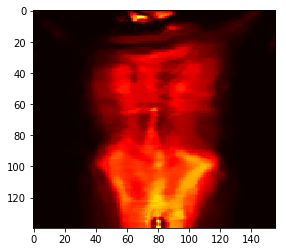

Score: 0.00129618193164
Heatmap:



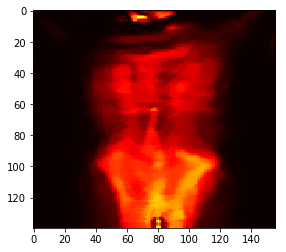

Score: 0.00107728114754
Heatmap:



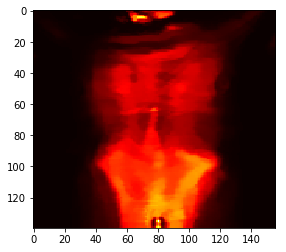

In [9]:
print('Plotting each heat map')
for item in range(len(valueList)):
    heat = np.zeros(myImg.shape)
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            heat[i][j] = valueList[item][i * myImg.shape[1] + j]
    print('Score: ' + str(scoreList[item]))
    print('Heatmap:\n')
    plt.imshow(heat, cmap='hot', interpolation='nearest')
    # plt.imshow(heat, cmap='hot', interpolation='nearest',alpha = .6)
    plt.show()

#### Trying seedList that is randomly taken in and outside of threat

--------Seed [30, 50]
Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.973101176082
Score: 0.853345723433

alpha: 2^-1
Correlation: 0.925417698221
Score: 0.777985762423

alpha: 2^-2
Correlation: 0.823364491774
Score: 0.654250243311

alpha: 2^-3
Correlation: 0.658214038912
Score: 0.488355693817

alpha: 2^-4
Correlation: 0.464747295132
Score: 0.31929044401

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.298159742414
Score: 0.18919421165

alpha: 2^-6
Correlation: 0.183432285943
Score: 0.107943948301

alpha: 2^-7
Correlation: 0.114092776985
Score: 0.0629609639599

alpha: 2^-8
Correlation: 0.0730836174459
Score: 0.0383331881645

alpha: 2^-9
Correlation: 0.0483400810672
Score: 0.0244003408745

alpha: 2^-10
Correlation: 0.031124795167
Score: 0.0152010265135

alpha: 2^-11
Correlation: 0.02004226227
Score: 0.00952578251086

alpha: 2^-12
Correlation: 0.013222814427
Score: 0.00615559050774

alpha: 2^-13
Correlation: 0.00927659715831
Score: 0.00425643773797

alpha: 2^-

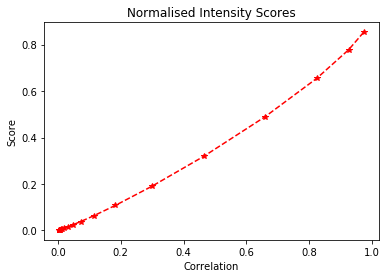

Plotting each heat map
Score: 0.853345723433
Heatmap:



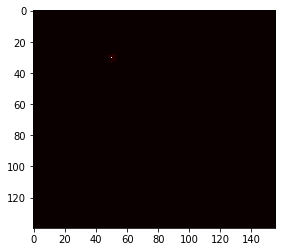

Score: 0.777985762423
Heatmap:



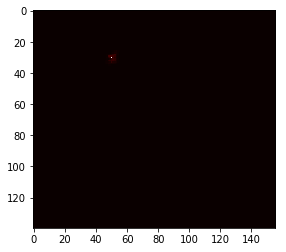

Score: 0.654250243311
Heatmap:



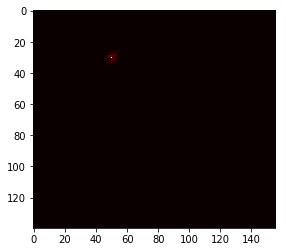

Score: 0.488355693817
Heatmap:



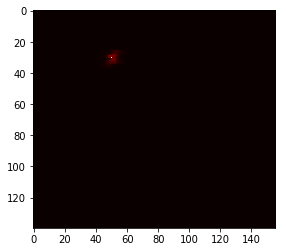

Score: 0.31929044401
Heatmap:



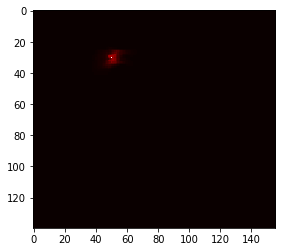

Score: 0.18919421165
Heatmap:



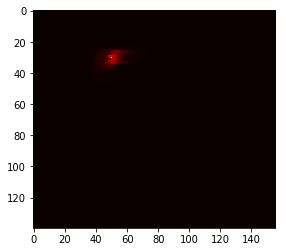

Score: 0.107943948301
Heatmap:



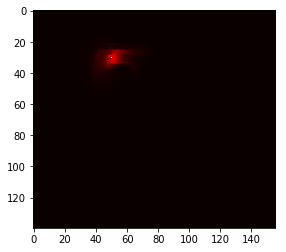

Score: 0.0629609639599
Heatmap:



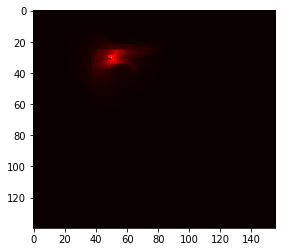

Score: 0.0383331881645
Heatmap:



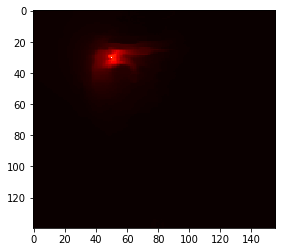

Score: 0.0244003408745
Heatmap:



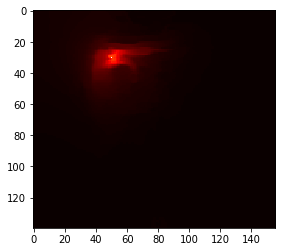

Score: 0.0152010265135
Heatmap:



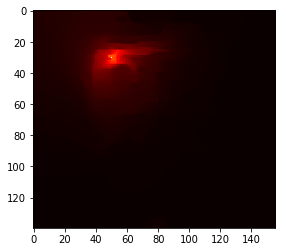

Score: 0.00952578251086
Heatmap:



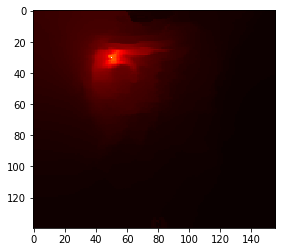

Score: 0.00615559050774
Heatmap:



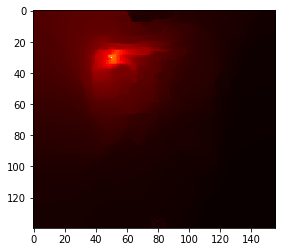

Score: 0.00425643773797
Heatmap:



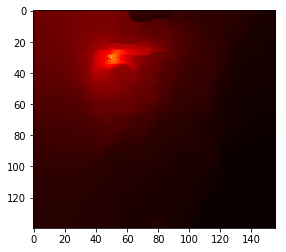

Score: 0.00322448548164
Heatmap:



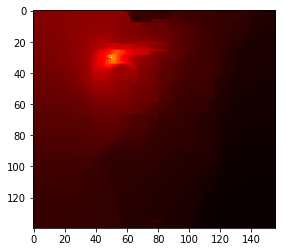

Score: 0.00254392034444
Heatmap:



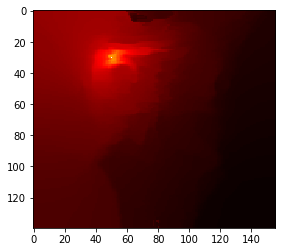

Score: 0.00229013422615
Heatmap:



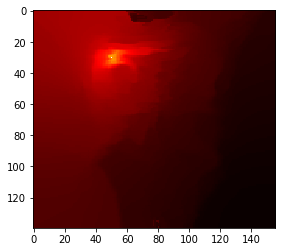

Score: 0.00223252076159
Heatmap:



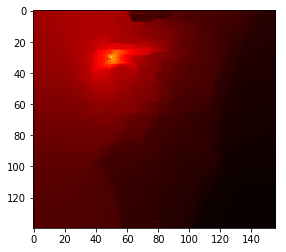

Score: 0.00211011193127
Heatmap:



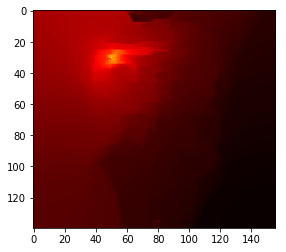

Score: 0.00209761026301
Heatmap:



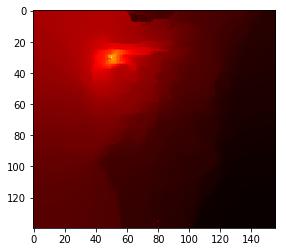

--------Seed [30, 80]
Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.966654723343
Score: 0.825879078855

alpha: 2^-1
Correlation: 0.906992912901
Score: 0.732788167259

alpha: 2^-2
Correlation: 0.784290965508
Score: 0.587186623116

alpha: 2^-3
Correlation: 0.602103306804
Score: 0.410601052796

alpha: 2^-4
Correlation: 0.413269768104
Score: 0.254497508141

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.266297643194
Score: 0.148401492317

alpha: 2^-6
Correlation: 0.168103093834
Score: 0.0855642900038

alpha: 2^-7
Correlation: 0.106487715744
Score: 0.0501534896522

alpha: 2^-8
Correlation: 0.0687709683892
Score: 0.0304246283278

alpha: 2^-9
Correlation: 0.0455362640928
Score: 0.0191979588385

alpha: 2^-10
Correlation: 0.0311278288717
Score: 0.0126701033456

alpha: 2^-11
Correlation: 0.0223868391467
Score: 0.00890591172756

alpha: 2^-12
Correlation: 0.0175503959706
Score: 0.00689892984599

alpha: 2^-13
Correlation: 0.0146938350348
Score: 0.00574216762219

alph

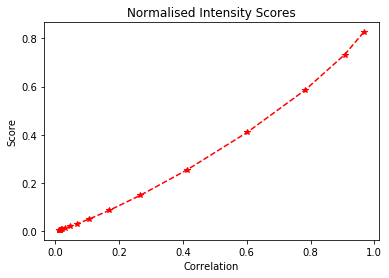

Plotting each heat map
Score: 0.825879078855
Heatmap:



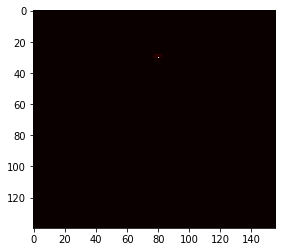

Score: 0.732788167259
Heatmap:



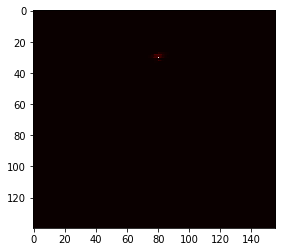

Score: 0.587186623116
Heatmap:



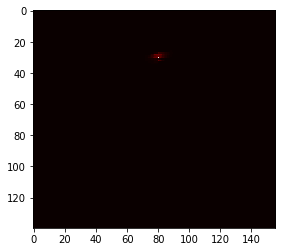

Score: 0.410601052796
Heatmap:



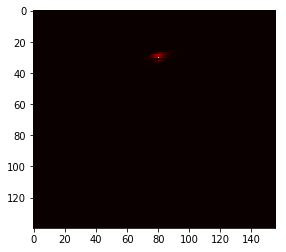

Score: 0.254497508141
Heatmap:



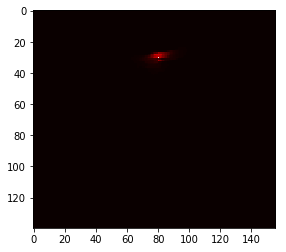

Score: 0.148401492317
Heatmap:



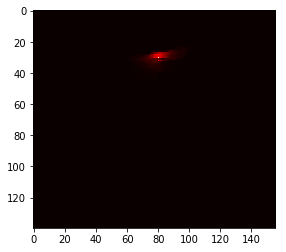

Score: 0.0855642900038
Heatmap:



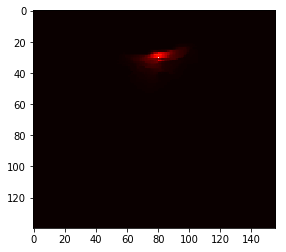

Score: 0.0501534896522
Heatmap:



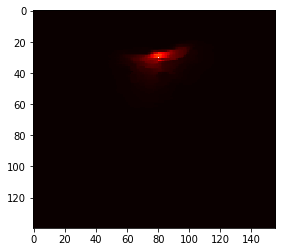

Score: 0.0304246283278
Heatmap:



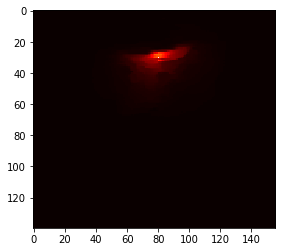

Score: 0.0191979588385
Heatmap:



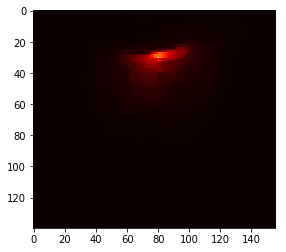

Score: 0.0126701033456
Heatmap:



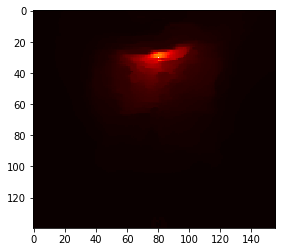

Score: 0.00890591172756
Heatmap:



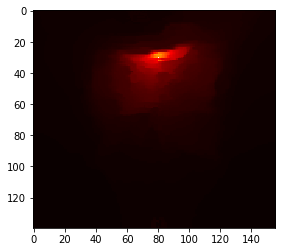

Score: 0.00689892984599
Heatmap:



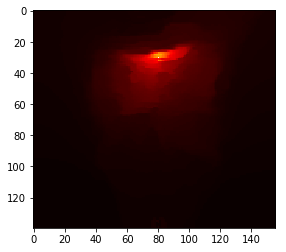

Score: 0.00574216762219
Heatmap:



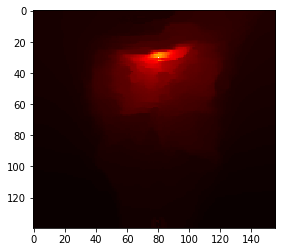

Score: 0.00531761921336
Heatmap:



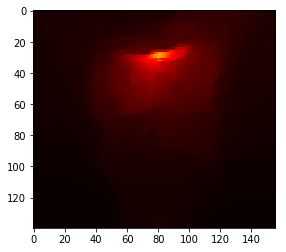

Score: 0.00499207316368
Heatmap:



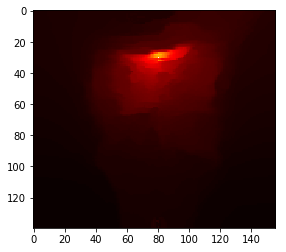

Score: 0.00482567453137
Heatmap:



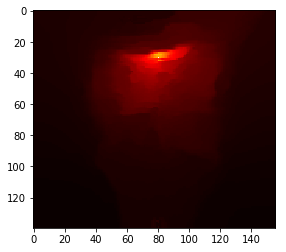

Score: 0.0048447107154
Heatmap:



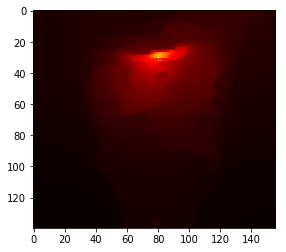

--------Seed [30, 110]
Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.98019498373
Score: 0.862103221193

alpha: 2^-1
Correlation: 0.949803424799
Score: 0.81399854099

alpha: 2^-2
Correlation: 0.887797526704
Score: 0.738294088045

alpha: 2^-3
Correlation: 0.777752799309
Score: 0.625346083448

alpha: 2^-4
Correlation: 0.612565810503
Score: 0.47414121167

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.419530657924
Score: 0.311057794377

alpha: 2^-6
Correlation: 0.254520146287
Score: 0.180148033089

alpha: 2^-7
Correlation: 0.143667451508
Score: 0.0969254678925

alpha: 2^-8
Correlation: 0.0792632876965
Score: 0.0510074161457

alpha: 2^-9
Correlation: 0.0438477223483
Score: 0.0269703167941

alpha: 2^-10
Correlation: 0.0247038844331
Score: 0.0145718292575

alpha: 2^-11
Correlation: 0.0147722121038
Score: 0.00841601693149

alpha: 2^-12
Correlation: 0.00929199459769
Score: 0.00515266097948

alpha: 2^-13
Correlation: 0.00651851522312
Score: 0.00355447767586

alpha

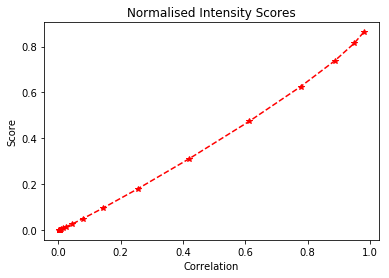

Plotting each heat map
Score: 0.862103221193
Heatmap:



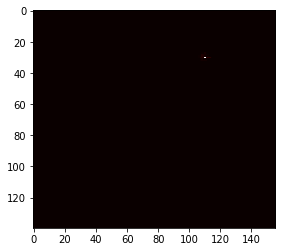

Score: 0.81399854099
Heatmap:



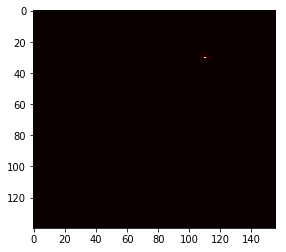

Score: 0.738294088045
Heatmap:



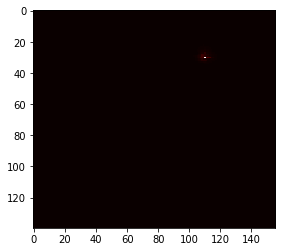

Score: 0.625346083448
Heatmap:



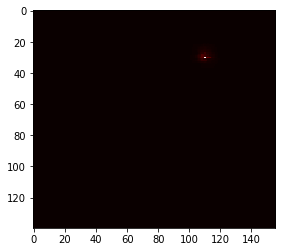

Score: 0.47414121167
Heatmap:



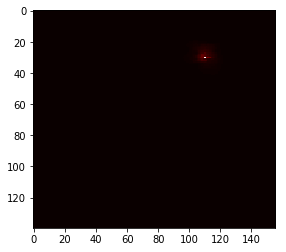

Score: 0.311057794377
Heatmap:



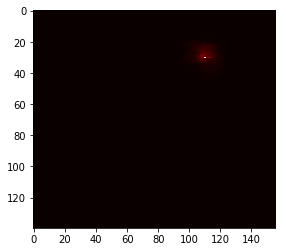

Score: 0.180148033089
Heatmap:



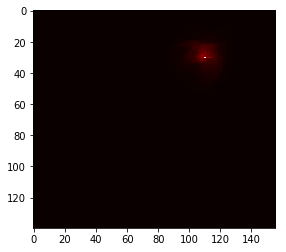

Score: 0.0969254678925
Heatmap:



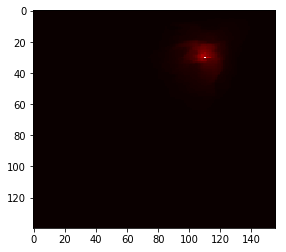

Score: 0.0510074161457
Heatmap:



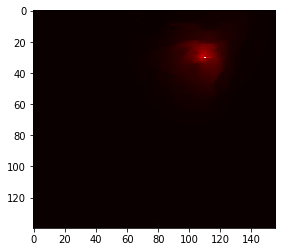

Score: 0.0269703167941
Heatmap:



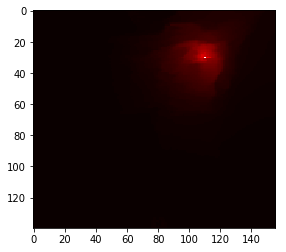

Score: 0.0145718292575
Heatmap:



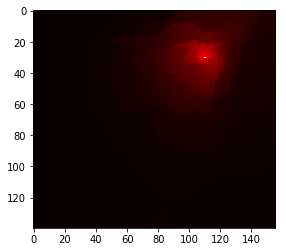

Score: 0.00841601693149
Heatmap:



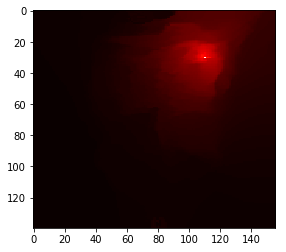

Score: 0.00515266097948
Heatmap:



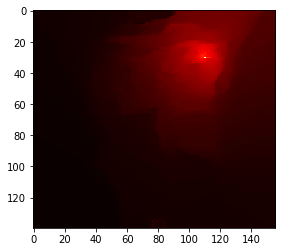

Score: 0.00355447767586
Heatmap:



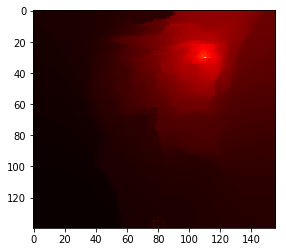

Score: 0.00282836421206
Heatmap:



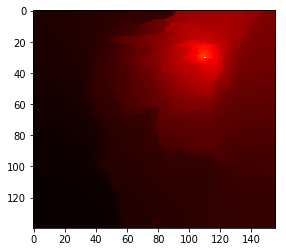

Score: 0.00225946105351
Heatmap:



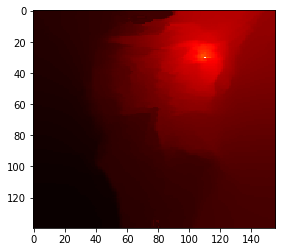

Score: 0.00204379077983
Heatmap:



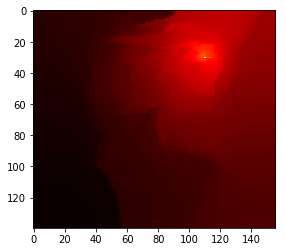

Score: 0.00191818036657
Heatmap:



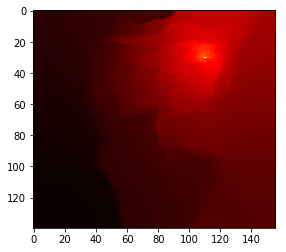

Score: 0.00187334762679
Heatmap:



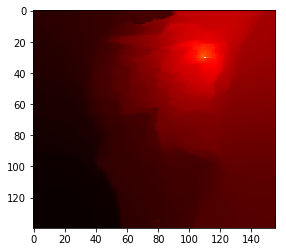

Score: 0.00180998404263
Heatmap:



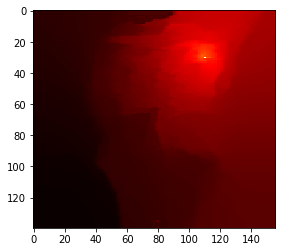

Score: 0.00175410969133
Heatmap:



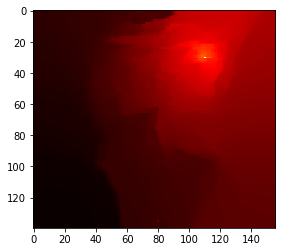

Score: 0.00187662179363
Heatmap:



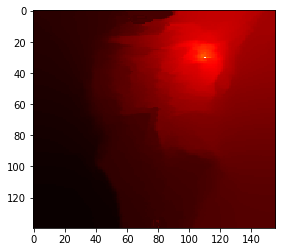

--------Seed [62, 50]
Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.982342956496
Score: 0.880590952914

alpha: 2^-1
Correlation: 0.951985944813
Score: 0.832207645171

alpha: 2^-2
Correlation: 0.881583478299
Score: 0.745297108023

alpha: 2^-3
Correlation: 0.745381519617
Score: 0.603606297285

alpha: 2^-4
Correlation: 0.548255295972
Score: 0.421136202951

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.349863943396
Score: 0.253030450874

alpha: 2^-6
Correlation: 0.204285911507
Score: 0.138663667647

alpha: 2^-7
Correlation: 0.115719655881
Score: 0.0737930939846

alpha: 2^-8
Correlation: 0.066268282856
Score: 0.0399103185738

alpha: 2^-9
Correlation: 0.0407182933599
Score: 0.0234470252831

alpha: 2^-10
Correlation: 0.0265417240236
Score: 0.0147814735304

alpha: 2^-11
Correlation: 0.0169983795335
Score: 0.00921128091612

alpha: 2^-12
Correlation: 0.0131009628375
Score: 0.00701347752747

alpha: 2^-13
Correlation: 0.00961646421828
Score: 0.005086932396

alpha: 

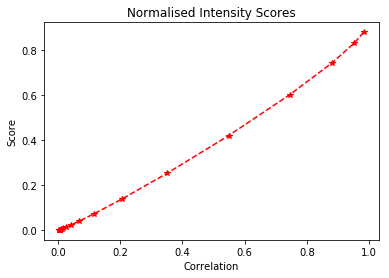

Plotting each heat map
Score: 0.880590952914
Heatmap:



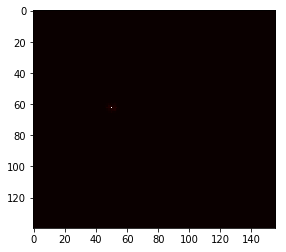

Score: 0.832207645171
Heatmap:



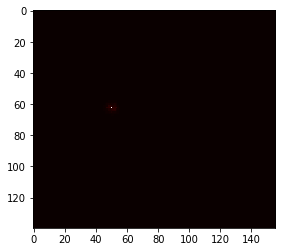

Score: 0.745297108023
Heatmap:



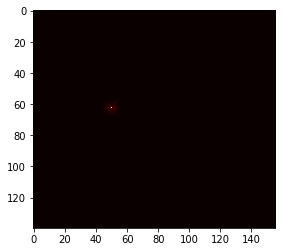

Score: 0.603606297285
Heatmap:



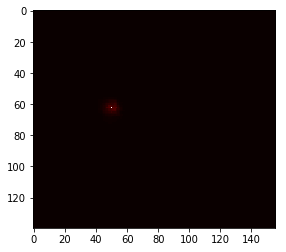

Score: 0.421136202951
Heatmap:



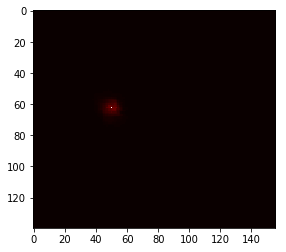

Score: 0.253030450874
Heatmap:



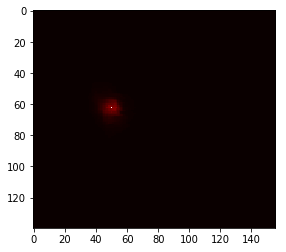

Score: 0.138663667647
Heatmap:



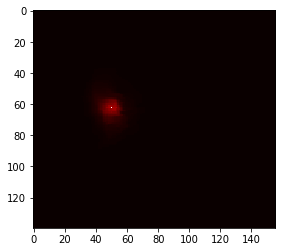

Score: 0.0737930939846
Heatmap:



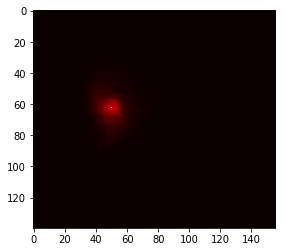

Score: 0.0399103185738
Heatmap:



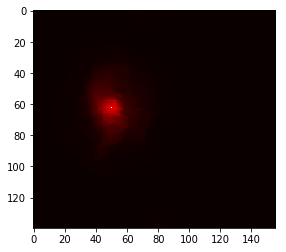

Score: 0.0234470252831
Heatmap:



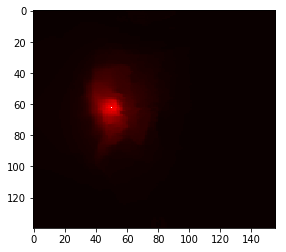

Score: 0.0147814735304
Heatmap:



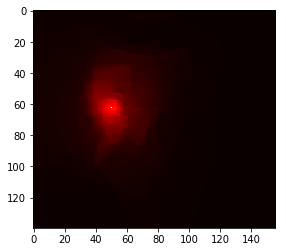

Score: 0.00921128091612
Heatmap:



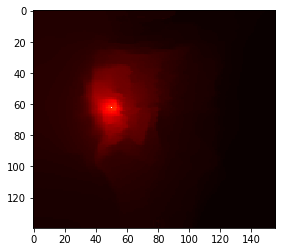

Score: 0.00701347752747
Heatmap:



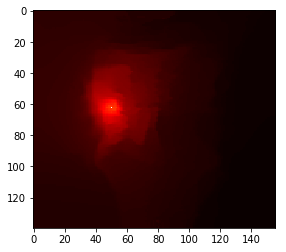

Score: 0.005086932396
Heatmap:



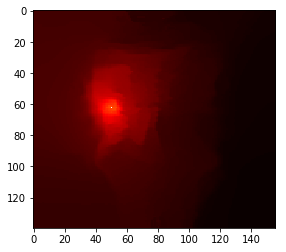

Score: 0.00371603184429
Heatmap:



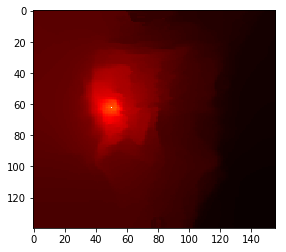

Score: 0.00302080928069
Heatmap:



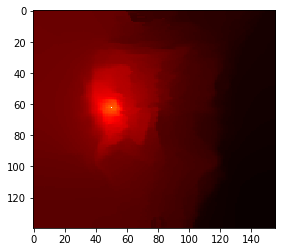

Score: 0.00273190562569
Heatmap:



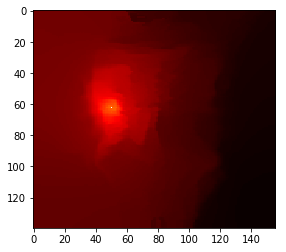

Score: 0.00260337556511
Heatmap:



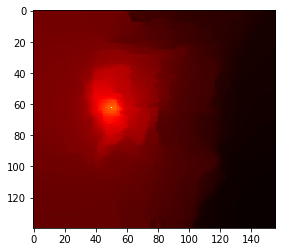

Score: 0.00229327302971
Heatmap:



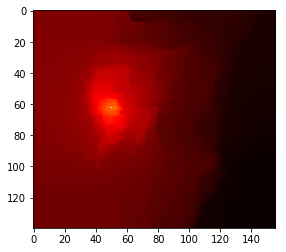

Score: 0.00234727015389
Heatmap:



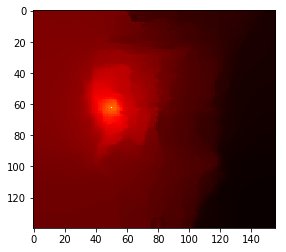

--------Seed [62, 80]
Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.970840938743
Score: 0.788334942145

alpha: 2^-1
Correlation: 0.930687894291
Score: 0.727130947263

alpha: 2^-2
Correlation: 0.858622920303
Score: 0.643918342298

alpha: 2^-3
Correlation: 0.748102185995
Score: 0.53861783443

alpha: 2^-4
Correlation: 0.603477450261
Score: 0.417622936055

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.448882372349
Score: 0.299432727293

alpha: 2^-6
Correlation: 0.313378987374
Score: 0.202419788361

alpha: 2^-7
Correlation: 0.208533640679
Score: 0.131021152044

alpha: 2^-8
Correlation: 0.132193116695
Score: 0.0810443109102

alpha: 2^-9
Correlation: 0.0811709309209
Score: 0.0486873737429

alpha: 2^-10
Correlation: 0.0489633478192
Score: 0.0288051763313

alpha: 2^-11
Correlation: 0.0320545580892
Score: 0.0186050682386

alpha: 2^-12
Correlation: 0.0232118500942
Score: 0.0133652808937

alpha: 2^-13
Correlation: 0.0186684322462
Score: 0.0107083628386

alpha: 2^-1

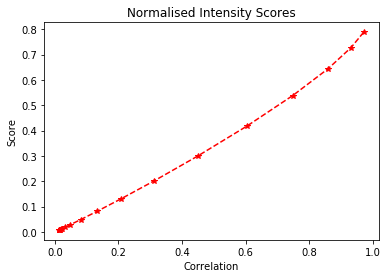

Plotting each heat map
Score: 0.788334942145
Heatmap:



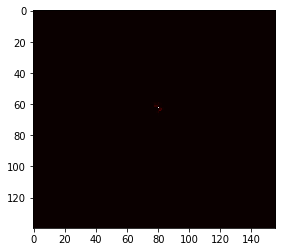

Score: 0.727130947263
Heatmap:



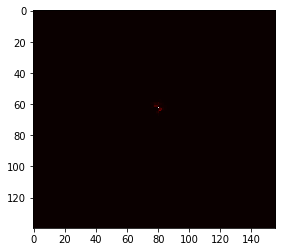

Score: 0.643918342298
Heatmap:



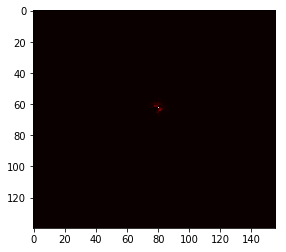

Score: 0.53861783443
Heatmap:



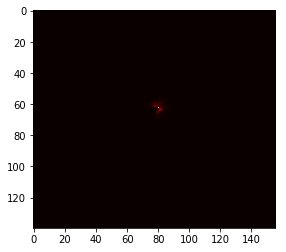

Score: 0.417622936055
Heatmap:



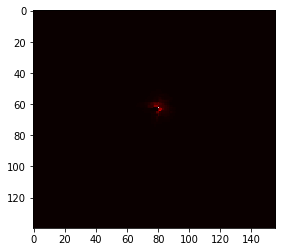

Score: 0.299432727293
Heatmap:



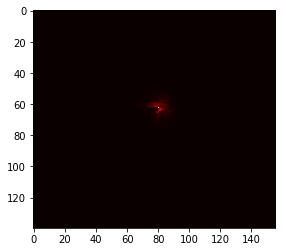

Score: 0.202419788361
Heatmap:



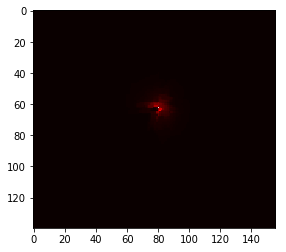

Score: 0.131021152044
Heatmap:



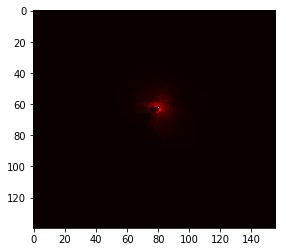

Score: 0.0810443109102
Heatmap:



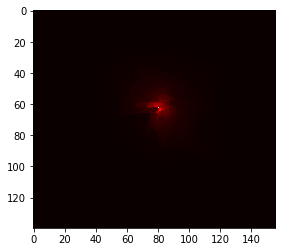

Score: 0.0486873737429
Heatmap:



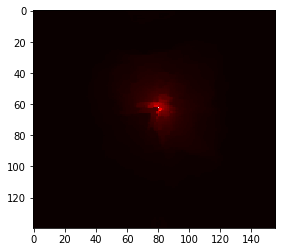

Score: 0.0288051763313
Heatmap:



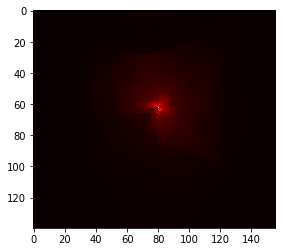

Score: 0.0186050682386
Heatmap:



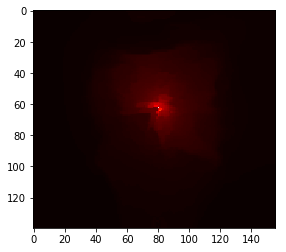

Score: 0.0133652808937
Heatmap:



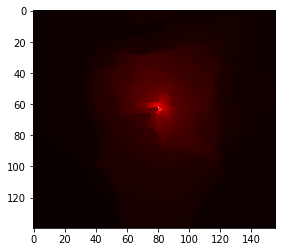

Score: 0.0107083628386
Heatmap:



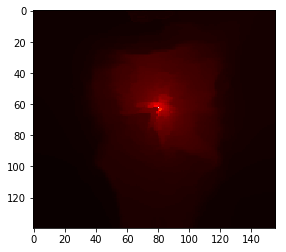

Score: 0.00941353811736
Heatmap:



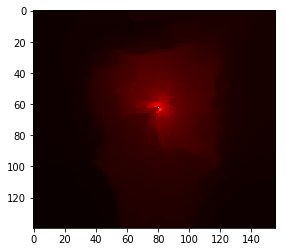

Score: 0.00864526176906
Heatmap:



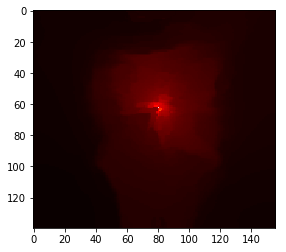

Score: 0.00827138827701
Heatmap:



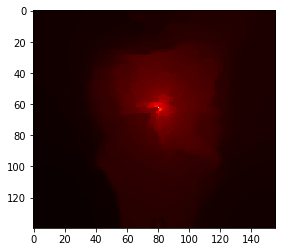

Score: 0.00810397924718
Heatmap:



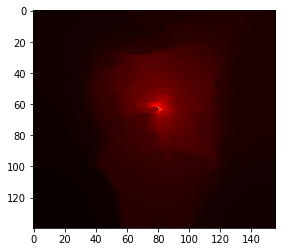

Score: 0.00813371980934
Heatmap:



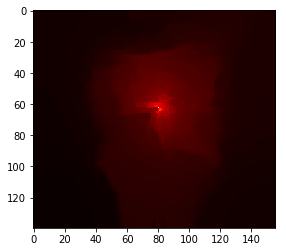

--------Seed [62, 110]
Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.973594048533
Score: 0.859456956509

alpha: 2^-1
Correlation: 0.926713149495
Score: 0.785126035539

alpha: 2^-2
Correlation: 0.826980954333
Score: 0.66358503496

alpha: 2^-3
Correlation: 0.668232128826
Score: 0.502941629862

alpha: 2^-4
Correlation: 0.485155501035
Score: 0.341245407831

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.327760431087
Score: 0.216303980577

alpha: 2^-6
Correlation: 0.213007499447
Score: 0.132867949983

alpha: 2^-7
Correlation: 0.13371339049
Score: 0.079312013133

alpha: 2^-8
Correlation: 0.0805879116243
Score: 0.0456127607019

alpha: 2^-9
Correlation: 0.0481911356814
Score: 0.0261540679063

alpha: 2^-10
Correlation: 0.0297746487399
Score: 0.0156060579468

alpha: 2^-11
Correlation: 0.0171822215614
Score: 0.00870617674571

alpha: 2^-12
Correlation: 0.0125033984197
Score: 0.00623323656043

alpha: 2^-13
Correlation: 0.00809035217732
Score: 0.00395858674077

alpha:

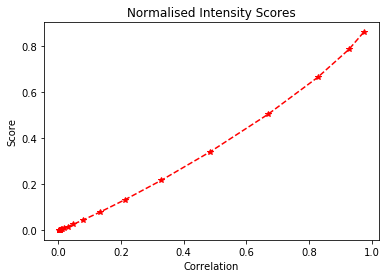

Plotting each heat map
Score: 0.859456956509
Heatmap:



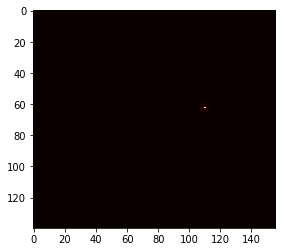

Score: 0.785126035539
Heatmap:



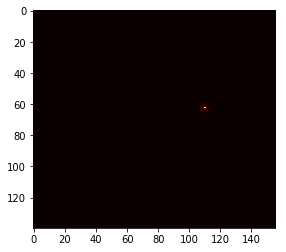

Score: 0.66358503496
Heatmap:



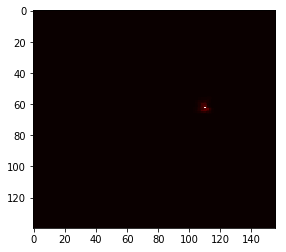

Score: 0.502941629862
Heatmap:



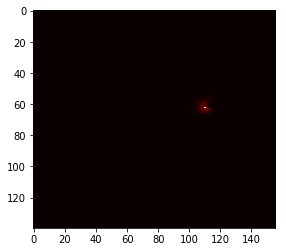

Score: 0.341245407831
Heatmap:



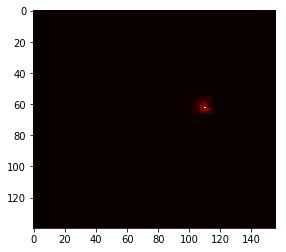

Score: 0.216303980577
Heatmap:



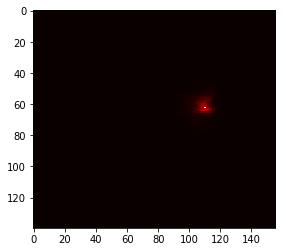

Score: 0.132867949983
Heatmap:



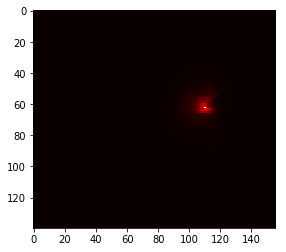

Score: 0.079312013133
Heatmap:



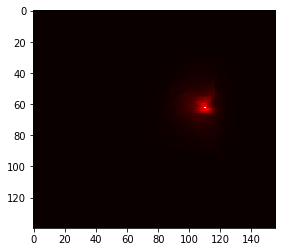

Score: 0.0456127607019
Heatmap:



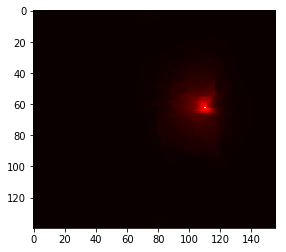

Score: 0.0261540679063
Heatmap:



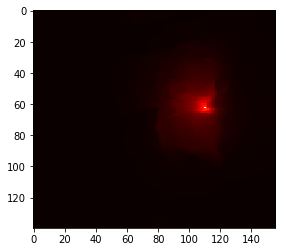

Score: 0.0156060579468
Heatmap:



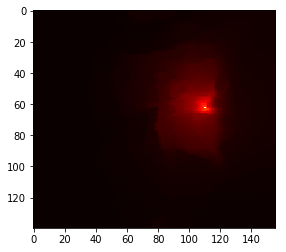

Score: 0.00870617674571
Heatmap:



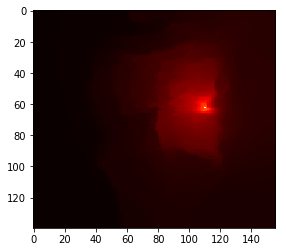

Score: 0.00623323656043
Heatmap:



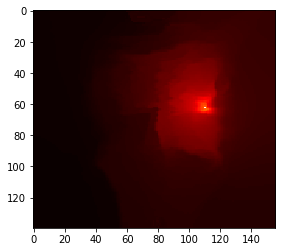

Score: 0.00395858674077
Heatmap:



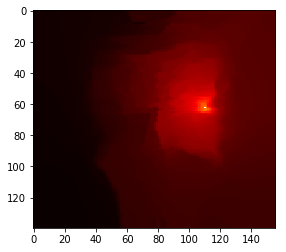

Score: 0.00290123203712
Heatmap:



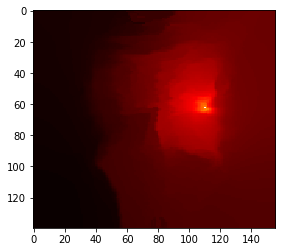

Score: 0.00241742642238
Heatmap:



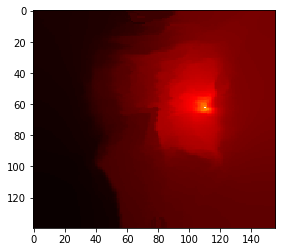

Score: 0.00211764731195
Heatmap:



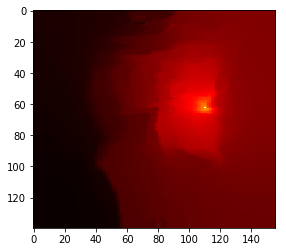

Score: 0.0018995233963
Heatmap:



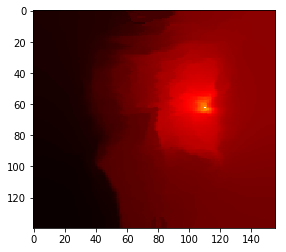

Score: 0.00183606192928
Heatmap:



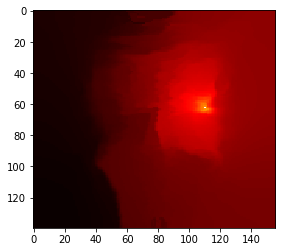

Score: 0.00169179118557
Heatmap:



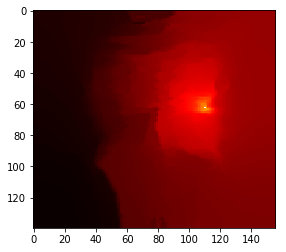

Score: 0.00180970792299
Heatmap:



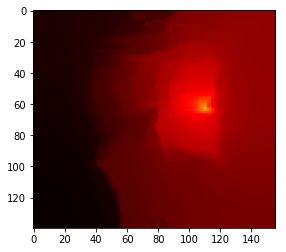

--------Seed [94, 50]
Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.977037951626
Score: 0.844124922537

alpha: 2^-1
Correlation: 0.942472319923
Score: 0.789863914716

alpha: 2^-2
Correlation: 0.874040921785
Score: 0.707399528847

alpha: 2^-3
Correlation: 0.757620573087
Score: 0.590117160115

alpha: 2^-4
Correlation: 0.589533961148
Score: 0.439985567484

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.399815587634
Score: 0.284457396883

alpha: 2^-6
Correlation: 0.239048330654
Score: 0.161343966501

alpha: 2^-7
Correlation: 0.132763025961
Score: 0.0847596987727

alpha: 2^-8
Correlation: 0.0722693931786
Score: 0.043639452268

alpha: 2^-9
Correlation: 0.0401096806031
Score: 0.0229804512226

alpha: 2^-10
Correlation: 0.0224988961832
Score: 0.0122668111328

alpha: 2^-11
Correlation: 0.0135401147692
Score: 0.00709481064941

alpha: 2^-12
Correlation: 0.00932807626103
Score: 0.0047712220472

alpha: 2^-13
Correlation: 0.00721777747659
Score: 0.0036467479387

alpha:

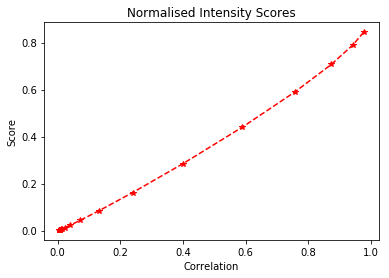

Plotting each heat map
Score: 0.844124922537
Heatmap:



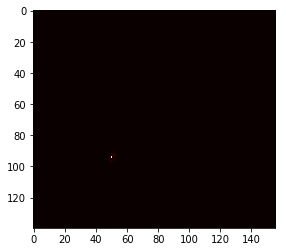

Score: 0.789863914716
Heatmap:



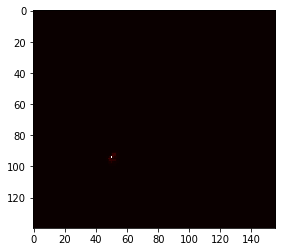

Score: 0.707399528847
Heatmap:



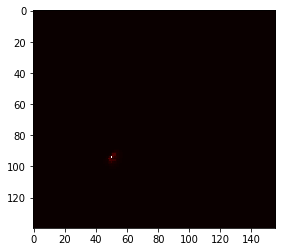

Score: 0.590117160115
Heatmap:



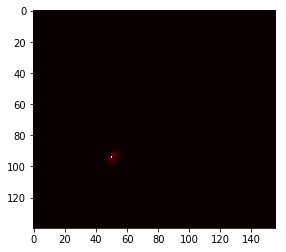

Score: 0.439985567484
Heatmap:



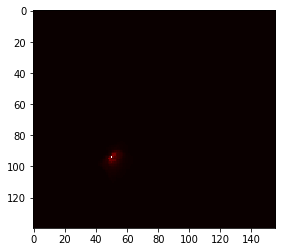

Score: 0.284457396883
Heatmap:



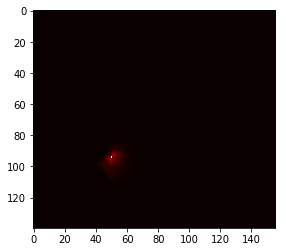

Score: 0.161343966501
Heatmap:



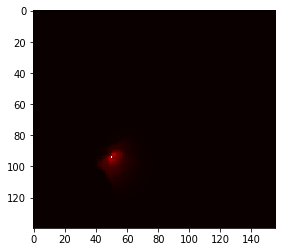

Score: 0.0847596987727
Heatmap:



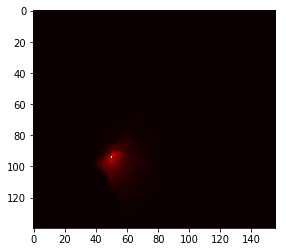

Score: 0.043639452268
Heatmap:



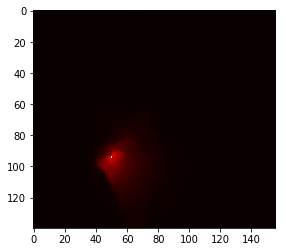

Score: 0.0229804512226
Heatmap:



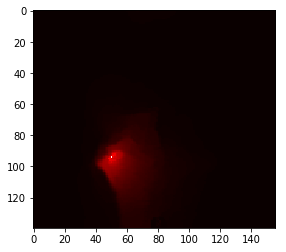

Score: 0.0122668111328
Heatmap:



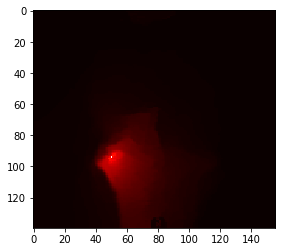

Score: 0.00709481064941
Heatmap:



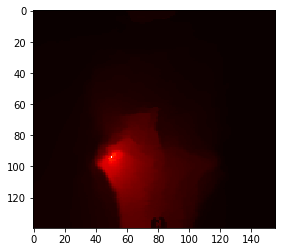

Score: 0.0047712220472
Heatmap:



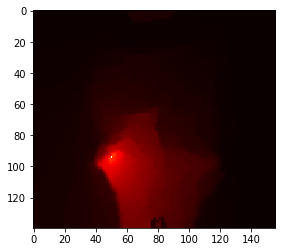

Score: 0.0036467479387
Heatmap:



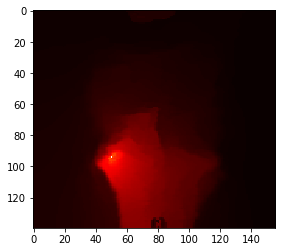

Score: 0.00306074251321
Heatmap:



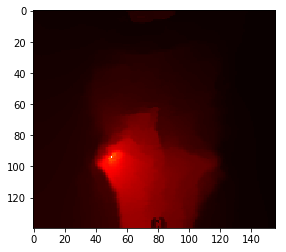

Score: 0.0028156823662
Heatmap:



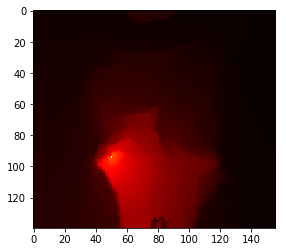

Score: 0.00268122825745
Heatmap:



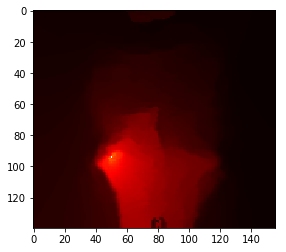

Score: 0.00267004354674
Heatmap:



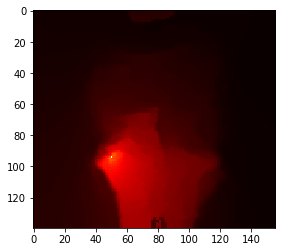

--------Seed [94, 80]
Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.971636391376
Score: 0.830778128186

alpha: 2^-1
Correlation: 0.92117349382
Score: 0.752118002793

alpha: 2^-2
Correlation: 0.817112749651
Score: 0.628281893552

alpha: 2^-3
Correlation: 0.656369738271
Score: 0.470538402992

alpha: 2^-4
Correlation: 0.480172275567
Score: 0.320712838863

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.335862968194
Score: 0.211054291283

alpha: 2^-6
Correlation: 0.232441865429
Score: 0.139246423508

alpha: 2^-7
Correlation: 0.158096816918
Score: 0.0911768968621

alpha: 2^-8
Correlation: 0.101430844047
Score: 0.0565173490132

alpha: 2^-9
Correlation: 0.0593008948624
Score: 0.0318838291606

alpha: 2^-10
Correlation: 0.0314494195559
Score: 0.0162488289878

alpha: 2^-11
Correlation: 0.0174992308136
Score: 0.00872703950924

alpha: 2^-12
Correlation: 0.0112861294549
Score: 0.00549996398685

alpha: 2^-13
Correlation: 0.0084463652747
Score: 0.00406886609139

alpha: 

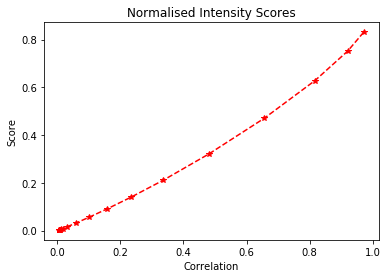

Plotting each heat map
Score: 0.830778128186
Heatmap:



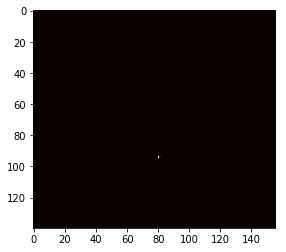

Score: 0.752118002793
Heatmap:



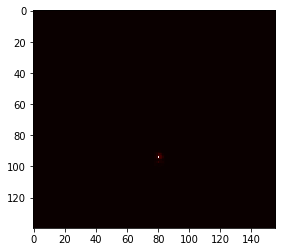

Score: 0.628281893552
Heatmap:



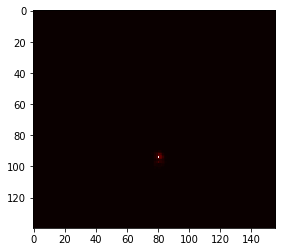

Score: 0.470538402992
Heatmap:



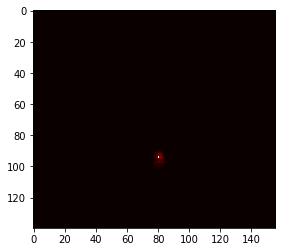

Score: 0.320712838863
Heatmap:



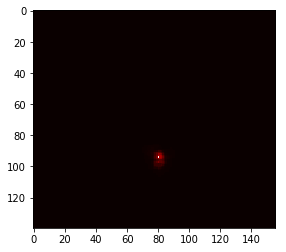

Score: 0.211054291283
Heatmap:



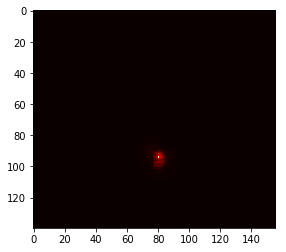

Score: 0.139246423508
Heatmap:



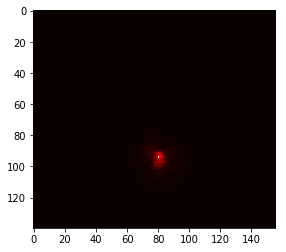

Score: 0.0911768968621
Heatmap:



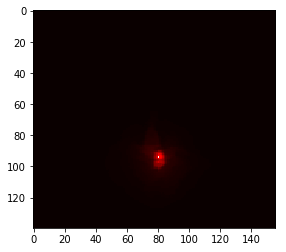

Score: 0.0565173490132
Heatmap:



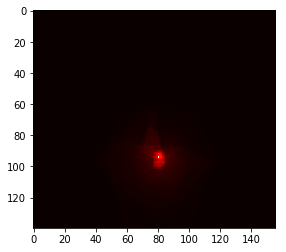

Score: 0.0318838291606
Heatmap:



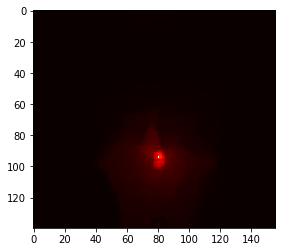

Score: 0.0162488289878
Heatmap:



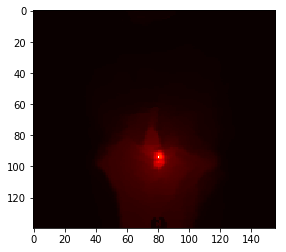

Score: 0.00872703950924
Heatmap:



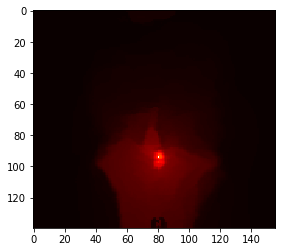

Score: 0.00549996398685
Heatmap:



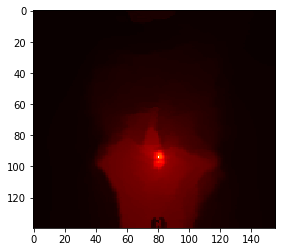

Score: 0.00406886609139
Heatmap:



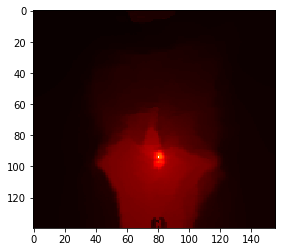

Score: 0.00341458548459
Heatmap:



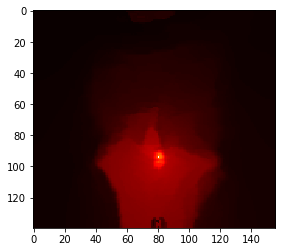

Score: 0.00311287645526
Heatmap:



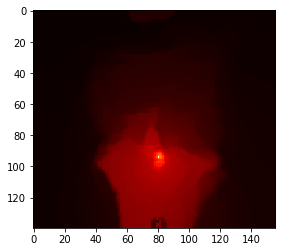

Score: 0.00296622902957
Heatmap:



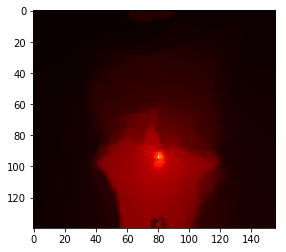

Score: 0.00289959207364
Heatmap:



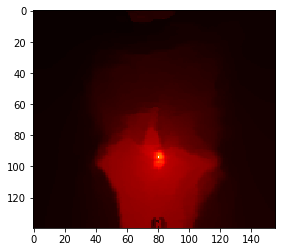

Score: 0.00283847156864
Heatmap:



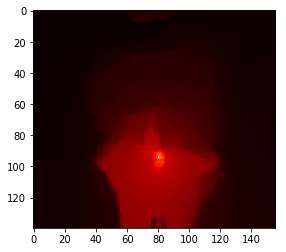

Score: 0.00282173560763
Heatmap:



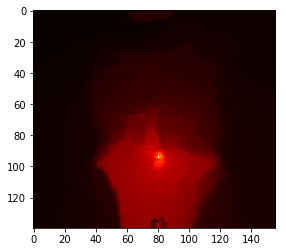

--------Seed [94, 110]
Threshold: 4.578754578754579e-05

alpha: 2^0
Correlation: 0.965461121524
Score: 0.793421320066

alpha: 2^-1
Correlation: 0.906434344746
Score: 0.703121436411

alpha: 2^-2
Correlation: 0.787764755842
Score: 0.566065290694

alpha: 2^-3
Correlation: 0.610777039319
Score: 0.400005387705

alpha: 2^-4
Correlation: 0.422950193911
Score: 0.250177919516

Starting correlation decrease check!

alpha: 2^-5
Correlation: 0.277816313278
Score: 0.149217247877

alpha: 2^-6
Correlation: 0.186482309935
Score: 0.0928448457004

alpha: 2^-7
Correlation: 0.13158381588
Score: 0.0622179414475

alpha: 2^-8
Correlation: 0.0954663773611
Score: 0.0436068050528

alpha: 2^-9
Correlation: 0.0685973540463
Score: 0.0305477000405

alpha: 2^-10
Correlation: 0.0463453962584
Score: 0.0201918056501

alpha: 2^-11
Correlation: 0.0322291299804
Score: 0.0138261914181

alpha: 2^-12
Correlation: 0.022078759454
Score: 0.00935061246808

alpha: 2^-13
Correlation: 0.0152134491796
Score: 0.00637974865129

alpha:

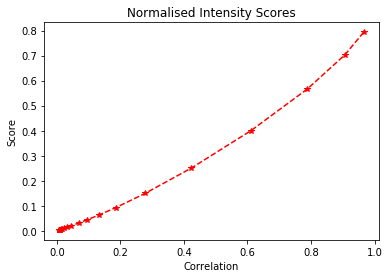

Plotting each heat map
Score: 0.793421320066
Heatmap:



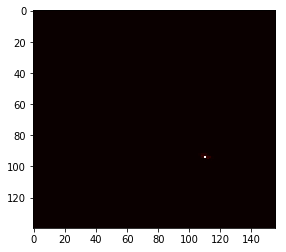

Score: 0.703121436411
Heatmap:



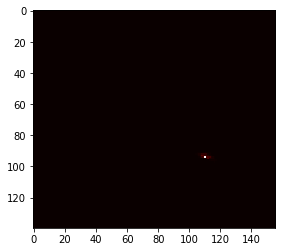

Score: 0.566065290694
Heatmap:



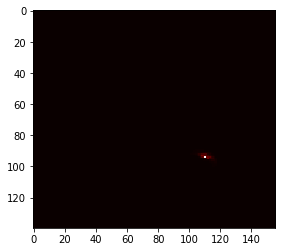

Score: 0.400005387705
Heatmap:



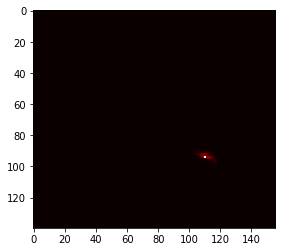

Score: 0.250177919516
Heatmap:



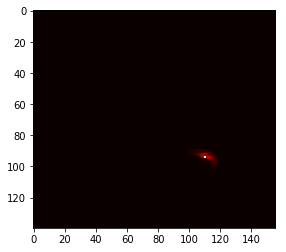

Score: 0.149217247877
Heatmap:



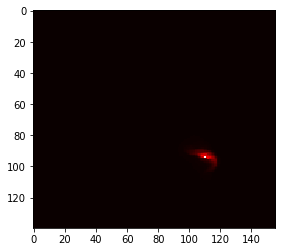

Score: 0.0928448457004
Heatmap:



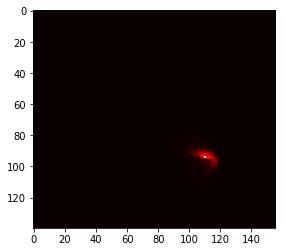

Score: 0.0622179414475
Heatmap:



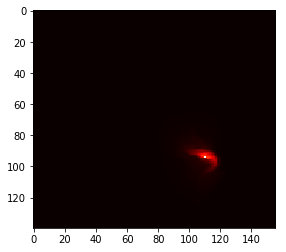

Score: 0.0436068050528
Heatmap:



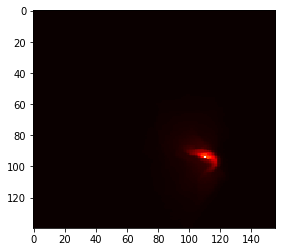

Score: 0.0305477000405
Heatmap:



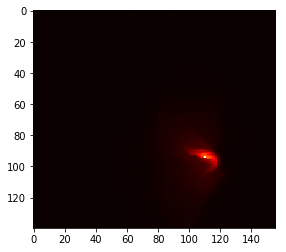

Score: 0.0201918056501
Heatmap:



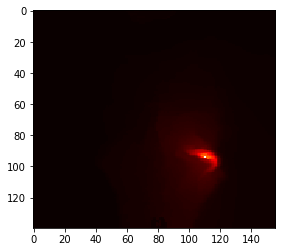

Score: 0.0138261914181
Heatmap:



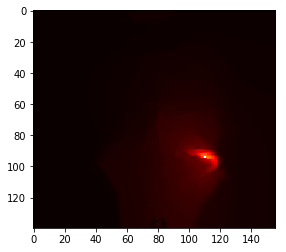

Score: 0.00935061246808
Heatmap:



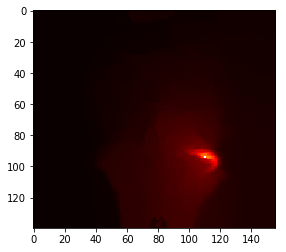

Score: 0.00637974865129
Heatmap:



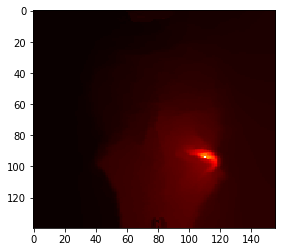

Score: 0.0049908985457
Heatmap:



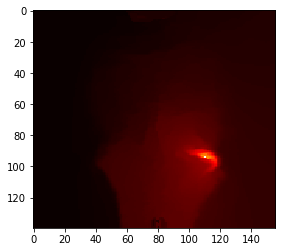

Score: 0.00416083466224
Heatmap:



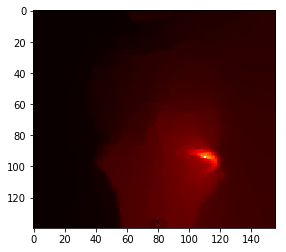

Score: 0.00365831080013
Heatmap:



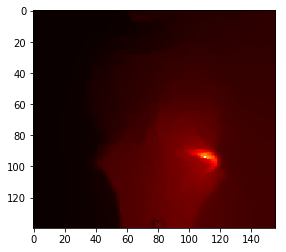

Score: 0.00357116784775
Heatmap:



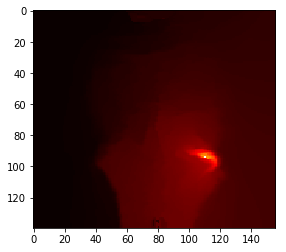

Score: 0.0034226901003
Heatmap:



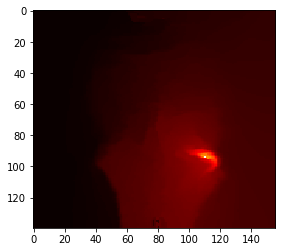

Score: 0.00331567997904
Heatmap:



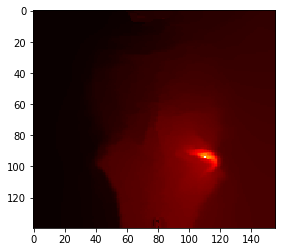

Score: 0.0034156356124
Heatmap:



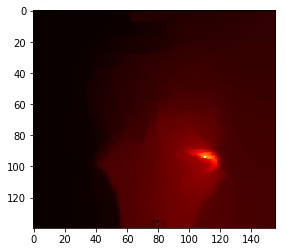

In [10]:
for elem in seedList[2:]:
    print('--------Seed ' + str(elem))
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    exponential = 0
    alpha = 2 ** exponential
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    # print(normalization)
    correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]

    print('Threshold: ' + str(1 / len(graph)))
    alphaList = []
    alphaList.append(alpha)

    correlationList = []
    correlationList.append(correlation)

    scoreList = []
    scoreList.append(score)

    valueList = []
    valueList.append(v)
    print('')
    print('alpha: 2^' + str(exponential))
    print('Correlation: ' + str(correlation))
    print('Score: ' + str(score))

    maxIterations = 29
    minIterations = 3
    for i in range(maxIterations):
        if correlation > 1 / len(graph):
            oldCorrelation = correlation
            exponential -= 1
            alpha = 2 ** exponential
            v = PRwalk(graph, alpha, s)
            normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
            correlation = \
                (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
            score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
            alphaList.append(alpha)
            correlationList.append(correlation)
            scoreList.append(score)
            valueList.append(v)
            print('')
            print('alpha: 2^' + str(exponential))
            print('Correlation: ' + str(correlation))
            print('Score: ' + str(score))
        if i == minIterations:
            print('')
            print('Starting correlation decrease check!')
        if i >= minIterations and oldCorrelation * .99 < correlation:
            break

    alphaListList.append(alphaList)
    correlationListList.append(correlationList)
    scoreListList.append(scoreList)
    valueListList.append(valueList)
    
    plt.plot(correlationList, scoreList, 'r*--')
    plt.xlabel('Correlation')
    plt.ylabel('Score')
    plt.title('Normalised Intensity Scores')
    plt.show()
    
    print('Plotting each heat map')
    for item in range(len(valueList)):
        heat = np.zeros(myImg.shape)
        for i in range(myImg.shape[0]):
            for j in range(myImg.shape[1]):
                heat[i][j] = valueList[item][i * myImg.shape[1] + j]
        print('Score: ' + str(scoreList[item]))
        print('Heatmap:\n')
        plt.imshow(heat, cmap='hot', interpolation='nearest')
        # plt.imshow(heat, cmap='hot', interpolation='nearest',alpha = .6)
        plt.show()

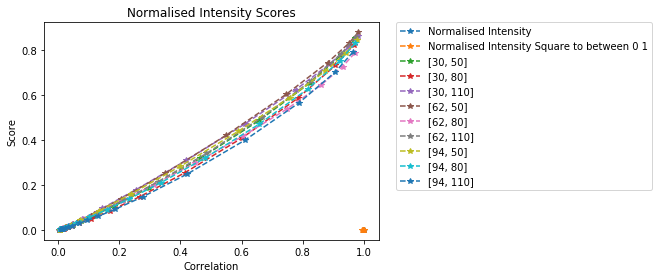

In [11]:
for i in range(len(correlationListList)):
    plt.plot(correlationListList[i], scoreListList[i], '*--')
plt.legend(seedList, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

In [12]:
import bcolz
def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [13]:
save_array(IMAGE + '/' + 'alphaListList.data', alphaListList)
save_array(IMAGE + '/' + 'correlationListList.data', correlationListList)
save_array(IMAGE + '/' + 'scoreListList.data', scoreListList)
save_array(IMAGE + '/' + 'valueListList.data', valueListList)
save_array(IMAGE + '/' + 'seedList.data', seedList[2:])

In [14]:
alphaListListRecovered = load_array(IMAGE + '/' + 'alphaListList.data')
correlationListListRecovered = load_array(IMAGE + '/' + 'correlationListList.data')
scoreListListRecovered = load_array(IMAGE + '/' + 'scoreListList.data')
valueListListRecovered = load_array(IMAGE + '/' + 'valueListList.data')
seedListRecovered = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1']
seedListRecovered[2:] = load_array(IMAGE + '/' + 'seedList.data')

Print with saved arrays for future usage


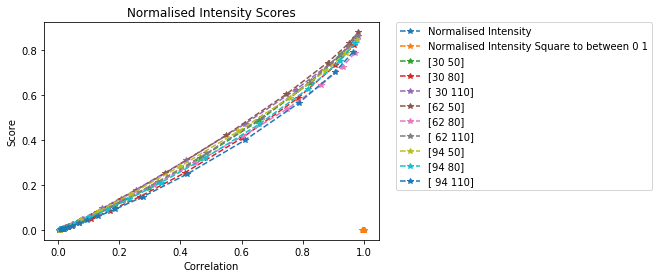

In [15]:
print('Print with saved arrays for future usage')
for i in range(len(correlationListListRecovered)):
    plt.plot(correlationListListRecovered[i], scoreListListRecovered[i], '*--')
plt.legend(seedListRecovered, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()